In this hands-on we will use the task2_data.csv (in the Library folder). This is the dataset that we used for investigating what makes a tweet relevant to a given topic.  Each instance (= each line in the data file) in this dataset lists the 25 features (25 columns) and the relevance judgement (the last field) for a (tweet, topic)-pair. You are encouraged to visualize and test more features.

### Calculating the P-value

In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu, ttest_ind
path='task2_data.csv'
df = pd.read_csv(path)


nr_entities_relevant = df[df['relevanceJudge'] == 1]['hasURL']
nr_entities_non_relevant = df[df['relevanceJudge'] == 0]['hasURL']

u, p_value = mannwhitneyu(nr_entities_non_relevant, nr_entities_relevant)
#u, p_value= ttest_ind(nr_entities_non_relevant, nr_entities_relevant)
print(p_value)

4.3250573436513435e-180


### Descriptive statistics

In this part you will obtain the descriptive statistics of the selected feature (e.g. hasURL)

In [2]:
print(nr_entities_relevant.describe())
print(nr_entities_non_relevant.describe())

count    2817.000000
mean        0.818956
std         0.385123
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: hasURL, dtype: float64
count    37138.000000
mean         0.541682
std          0.498266
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: hasURL, dtype: float64


### Visualization 

Try to visualize the different features.

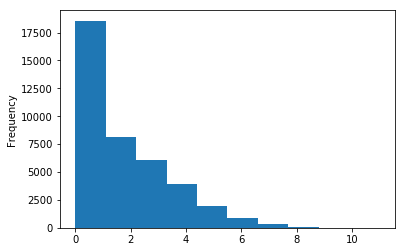

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

nr_entities = df['#entities']
nr_entities.plot(kind='hist')
plt.show()

Another example of visualization. For relevant tweets, we show the number of tweets with URL (i.e. 1), and without URL (i.e. 0)

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

relevant_entities = df[df['relevanceJudge'] == 1]['hasURL']

relevant_entities.plot(kind='hist')
plt.show()

## Predictive Model

In [1]:
import functools
import io
import numpy as np
import sys

genfromtxt_old = np.genfromtxt
@functools.wraps(genfromtxt_old)
def genfromtxt_py3_fixed(f, encoding="utf-8", *args, **kwargs):
  if isinstance(f, io.TextIOBase):
    if hasattr(f, "buffer") and hasattr(f.buffer, "raw") and \
    isinstance(f.buffer.raw, io.FileIO):
      # Best case: get underlying FileIO stream (binary!) and use that
      fb = f.buffer.raw
      # Reset cursor on the underlying object to match that on wrapper
      fb.seek(f.tell())
      result = genfromtxt_old(fb, *args, **kwargs)
      # Reset cursor on wrapper to match that of the underlying object
      f.seek(fb.tell())
    else:
      # Not very good but works: Put entire contents into BytesIO object,
      # otherwise same ideas as above
      old_cursor_pos = f.tell()
      fb = io.BytesIO(bytes(f.read(), encoding=encoding))
      result = genfromtxt_old(fb, *args, **kwargs)
      f.seek(old_cursor_pos + fb.tell())
  else:
    result = genfromtxt_old(f, *args, **kwargs)
  return result

## Logistic Regression

In [2]:
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
def train_logistic_regression(path):

    dataset=genfromtxt_py3_fixed(open(path,'r'), delimiter=',', skip_header=1)

    trainData = np.array([x[:-1] for x in dataset])
    labelData=np.array([x[-1] for x in dataset])
    X_train, X_test, y_train, y_test = train_test_split(trainData, labelData, test_size=0.20,random_state=10)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    print(clf.coef_)


    y_pred = clf.predict(X_test)

    print('F-score: ',precision_score(y_test, y_pred))
    print('Recall: ',recall_score(y_test,y_pred))
    print('Fscore: ',f1_score(y_test,y_pred))

train_logistic_regression('task2_data.csv')


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 1.30792971e-01  1.37686592e-01  4.48549549e-03  9.18164668e-02
  -2.88845080e-02  3.58387054e-03 -1.81378827e-02  6.94253353e-03
   4.87329493e-02  2.95047278e-02  7.40950719e-02  2.74937187e-02
   1.18857311e-02 -2.30031691e-02 -2.05255801e-03 -1.88437865e-03
   1.06431398e-02 -4.14655858e-06  1.32636318e-05 -4.85486483e-07
   1.75548519e-04  1.60141006e-03  6.07885975e-04  5.32833798e-02
   4.25401753e-07]]
F-score:  1.0
Recall:  0.0016750418760469012
Fscore:  0.0033444816053511705


## Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
def train_random_forest(path):
    dataset=genfromtxt_py3_fixed(open(path,'r'), delimiter=',', skip_header=1)

    trainData = np.array([x[:-1] for x in dataset])
    labelData=np.array([x[-1] for x in dataset])
    X_train, X_test, y_train, y_test = train_test_split(trainData, labelData, test_size=0.50,random_state=10)
    clf = RandomForestClassifier(max_depth=10, n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print('Precision: ',precision_score(y_test, y_pred))
    print('Recall: ',recall_score(y_test,y_pred))
    print('F-Score: ',f1_score(y_test,y_pred))
    
train_random_forest('task2_data.csv')

Precision:  0.8020477815699659
Recall:  0.16387726638772665
F-Score:  0.2721482339316734


# Assignment

In [4]:
import re
def hasUrl(string): 

    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+] |[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url 

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['neg'],score['neu'],score['pos']

In [6]:
import csv
import random

newfile_path='SAIL_subset_enriched.csv'
enriched_file=open(newfile_path,'w')
with open('SAIL_subset.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    #skip first line
    next(csv_reader)
  
    for row in csv_reader:
        if hasUrl(row[5])==[]:
              #no url in text
              url_feature=0
        else:
            #text contains an url
            url_feature=1
        if row[8]==[]:
              #no hashtag in text
              hashtag_feature=0
        else:
            #text contains a hashtag
            hashtag_feature=1
            
        length_feature=len(row[5])
        negative_sentiment,neutral_sentiment,positive_sentiment=sentiment_analyzer_scores(row[5])
        enriched_file.write(str(length_feature)+','+str(url_feature)+','+str(hashtag_feature)+','+str(negative_sentiment)+','+str(neutral_sentiment)+','+str(positive_sentiment)+','+str(random.randint(0, 1))+'\n')
                            
enriched_file.close()
print('Training logistic regression...')
train_logistic_regression(newfile_path)
print('Training random forest...')
train_random_forest(newfile_path)

Training logistic regression...


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 9.43938125e-05  1.78631957e-01 -5.01226417e-03 -5.00017655e-01
   1.02821445e-02 -2.98420694e-02]]
F-score:  0.5034526051475204
Recall:  0.8044132397191575
Fscore:  0.6193050193050192
Training random forest...
Precision:  0.5018175209014903
Recall:  0.549562101910828
F-Score:  0.5246057381721451
